In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.feature_selection import SelectKBest, chi2
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
# Carregar o dataset
df = pd.read_csv("/content/drive/MyDrive/base_tjsp.csv")

# Estrutura do dataset
shape_data = df.shape
print(f"O dataset possui {shape_data[0]} linhas e {shape_data[1]} atributos.")
df.head(3)

O dataset possui 300 linhas e 17 atributos.


,cdacordao,termos_frequentes,processo,classe,assunto,relator,comarca,orgao_julgador,data_julgamento,data_publicacao,ementa,julgado,topic,classificacao_level0,classificacao_level1,classificacao_level2,observacoes
0,1170177,runs faces,90062675920058253312,Habeas Corpus,Furto,Eduardo Pereira,Comarca nâo informada,12ª Câmara de Direito Criminal,NaN,NaN,"HABEAS CORPUS n"" 880736/8\r\nComarca: SÃO PAUL...",?v\r\n\r\n PODER ...,1,0,NaN,NaN,Não é crime cibernético.
1,2591479,hosting dados providers,90520622020078256138,Agravo de Instrumento,DOMÍNIO DE MARCA VIRTUAL,Egidio Giacoia,Ribeirão Preto,3ª Câmara de Direito Privado,2008-04-29,NaN,"AGRAVO DE INSTRUMENTO - Obrigação de Fazer - ""...",PODER JUDICIÁRIO\r\n ...,3,1,C,C4,Difamação através de redes sociais
2,4854160,bancos cheques dados dozes sites trojans,91175363520078266378,Apelação Cível,Cartão de Crédito,Ricardo Negrão,São Vicente,19ª Câmara de Direito Privado,2010-10-26,NaN,DANO MORAL - Banco de dados - Inclusão indevid...,3\r\n°l ...,2,0,NaN,NaN,Não é crime cibernético.


In [6]:
# Proporção da classificação 'Crime Cibernético', 'Outros'
proporcao = df['classificacao_level0'].value_counts(normalize=True)

for classe, prop in proporcao.items():
    print(f"Classe {classe}: {prop*100:.2f}%")

Classe 1: 55.33%
Classe 0: 44.67%


In [7]:
# Juntar texto da ementa e do acórdão
df_modelo = df.copy()
df_modelo["texto_completo"] = df["ementa"] + " " + df["julgado"]

In [8]:
# Adicionar uma coluna de ano julgamento
df_modelo['ano_julgamento'] = df_modelo['data_julgamento'].str.extract(r'(\d{4})')

# Adicionar uma coluna de período com base no ano julgamento
conditions = [
    df_modelo['ano_julgamento'].isin(['2010', '2011', '2012', '2013', '2014', '2015']),
    df_modelo['ano_julgamento'].isin(['2016', '2017', '2018', '2019', '2020']),
    df_modelo['ano_julgamento'].isin(['2021', '2022', '2023', '2024'])
]
choices = ['2010-2015', '2016-2020', 'após 2020']
df_modelo['periodo'] = np.select(conditions, choices, default='anterior a 2010')

In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords_pt = set(stopwords.words('portuguese'))

# Criar listas com nomes dos relatores, cidades e órgãos julgadores para serem removidos do texto
nome_relator = "|".join(df_modelo['relator'].dropna().str.lower().unique())
nome_cidade = "|".join(df_modelo['comarca'].dropna().str.lower().unique())
nome_orgao = "|".join(df_modelo['orgao_julgador'].dropna().str.lower().unique())


# Pré-processar texto completo
def preprocess_text(text):
    if pd.isnull(text):
        return ""

    text = text.lower()
    text = re.sub(r".*?(acórdão)", " ", text)

    # Remover cabeçalhos, assinaturas, nomes, datas, e outros padrões
    substitutions = [
        r"poder judiciário\s+tribunal de justiça (do estado de são paulo|do estado)?",
        r"tribunal de justiça\s+poder judiciário",
        r"assinatura eletrônica",
        r"\n",
        nome_relator,
        nome_cidade,
        nome_orgao,
        r"\b\d{1,2}[-/.]\d{1,2}[-/.]\d{2,4}\b",
        r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.(com|com\.br)\b",
        r"https?://\S+|www\.\S+",
        r"[ºª°]",
        r"[0-9]",
        r"\b[A-Za-z]\b",
    ]

    for pattern in substitutions:
        text = re.sub(pattern, " ", text)

    # Remover pontuação e espaços extras
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenizar
    text = word_tokenize(text)

    # Remover stopwords
    text = [word for word in text if word not in stopwords_pt]

    # Lemantizar
    text = [lemmatizer.lemmatize(word) for word in text]

    return text

# Aplicar pré-processamento
df_modelo['texto_tratado'] = df_modelo['texto_completo'].apply(preprocess_text)

In [10]:
# Representar texto por TF_IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df_modelo['texto_tratado'].apply(lambda x: ' '.join(x)))

In [11]:
# One-Hot Encode nas colunas categóricas
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat = encoder.fit_transform(df_modelo[['classe', 'assunto', 'topic', 'periodo']])

# Combinar TF-IDF e One-Hot Encoding
X_combined = hstack([X_tfidf, X_cat])

# Separar features e target
X = X_combined
y = df_modelo['classificacao_level0']

# Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Nova estrutura do dataset
print(f"Shape dos dados combinados: {X_combined.shape}")

Shape dos dados combinados: (300, 30783)


In [12]:
# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Testar diferentes valores de número de atributos
k_values = [100, 300, 500, 1000, 2000, 3000, 5000, 7000]

SVM

k=100 → F1 médio: 0.7803 | Desvio padrão: 0.0690
k=300 → F1 médio: 0.7910 | Desvio padrão: 0.0921
k=500 → F1 médio: 0.7922 | Desvio padrão: 0.0857
k=1000 → F1 médio: 0.7998 | Desvio padrão: 0.0807
k=2000 → F1 médio: 0.8050 | Desvio padrão: 0.0806
k=3000 → F1 médio: 0.8165 | Desvio padrão: 0.0890
k=5000 → F1 médio: 0.8036 | Desvio padrão: 0.1043
k=7000 → F1 médio: 0.8107 | Desvio padrão: 0.0997

 Melhor modelo: SVM com k=3000 → F1 médio: 0.8165


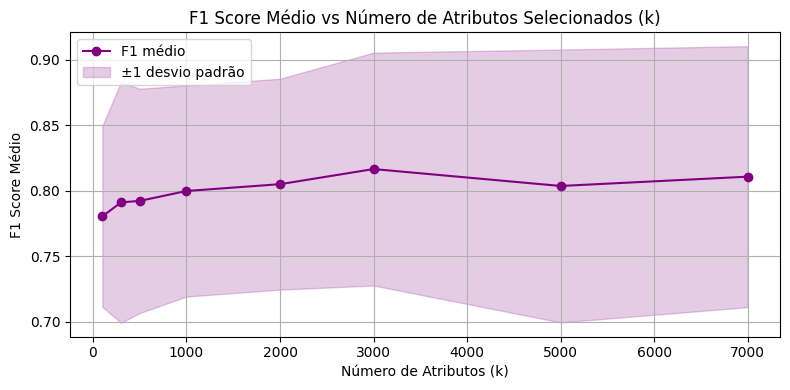

In [13]:
resultados = []

for k in k_values:
    pipe = Pipeline([
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('svm', SVC(kernel='linear', probability=True, random_state=42))
    ])

    # Avaliação cruzada com valor de F1
    f1_scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    media = np.mean(f1_scores)
    std = np.std(f1_scores)

    resultados.append({
        "nome": f"SVM com k={k}",
        "k": k,
        "f1_mean": media,
        "f1_std": std,
        "scores": f1_scores
    })

    print(f"k={k} → F1 médio: {media:.4f} | Desvio padrão: {std:.4f}")

# Identificar o melhor valor de k com maior F1 médio
melhor = max(resultados, key=lambda x: x["f1_mean"])
print(f"\n Melhor modelo: {melhor['nome']} → F1 médio: {melhor['f1_mean']:.4f}")

# Gráfico da curva F1 vs k
plt.figure(figsize=(8, 4))
plt.plot([r['k'] for r in resultados], [r['f1_mean'] for r in resultados], marker='o', label='F1 médio', color='purple')
plt.fill_between(
    [r['k'] for r in resultados],
    [r['f1_mean'] - r['f1_std'] for r in resultados],
    [r['f1_mean'] + r['f1_std'] for r in resultados],
    color='purple', alpha=0.2, label='±1 desvio padrão'
)
plt.title("F1 Score Médio vs Número de Atributos Selecionados (k)")
plt.xlabel("Número de Atributos (k)")
plt.ylabel("F1 Score Médio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Avaliação Final do Melhor Modelo: SVM com k=3000
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        27
           1       0.79      0.79      0.79        33

    accuracy                           0.77        60
   macro avg       0.76      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60

Accuracy: 0.7666666666666667
Precision: 0.7878787878787878
Recall: 0.7878787878787878
F1 Score: 0.7878787878787878
ROC AUC Score: 0.8462401795735129


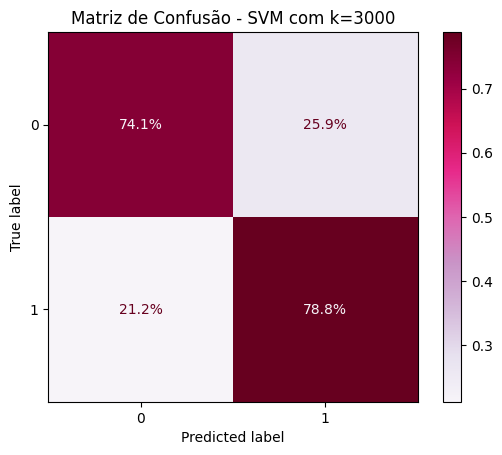

In [14]:
# Repetir a seleção com o melhor k encontrado
melhor_k = melhor['k']

# Separar os dados para avaliação final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Criar e treinar o modelo com o melhor k
pipe_final = Pipeline([
    ('select', SelectKBest(score_func=chi2, k=melhor_k)),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])
pipe_final.fit(X_train_final, y_train_final)

# Fazer previsões no teste final
y_pred_final = pipe_final.predict(X_test_final)
y_prob_final = pipe_final.predict_proba(X_test_final)[:, 1]

# Métricas
print(f"\n Avaliação Final do Melhor Modelo: SVM com k={melhor_k}")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_final.named_steps['svm'].classes_)
disp.plot(cmap="PuRd", values_format=".1%")
plt.title(f"Matriz de Confusão - SVM com k={melhor_k}")
plt.show()


Regressão logística

k=100 → F1 médio: 0.7647 | Desvio padrão: 0.0939
k=300 → F1 médio: 0.7756 | Desvio padrão: 0.0869
k=500 → F1 médio: 0.7909 | Desvio padrão: 0.0834
k=1000 → F1 médio: 0.7925 | Desvio padrão: 0.0741
k=2000 → F1 médio: 0.7966 | Desvio padrão: 0.0627
k=3000 → F1 médio: 0.8039 | Desvio padrão: 0.0672
k=5000 → F1 médio: 0.7878 | Desvio padrão: 0.0788
k=7000 → F1 médio: 0.7878 | Desvio padrão: 0.0788

 Melhor modelo: Regressão Logística com k=3000 → F1 médio: 0.8039


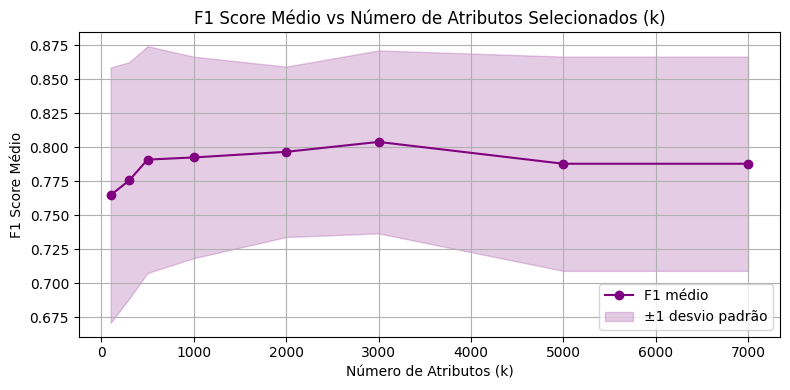

In [15]:
resultados = []

for k in k_values:
    pipe = Pipeline([
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Avaliação cruzada com valor de F1
    f1_scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    media = np.mean(f1_scores)
    std = np.std(f1_scores)

    resultados.append({
        "nome": f"Regressão Logística com k={k}",
        "k": k,
        "f1_mean": media,
        "f1_std": std,
        "scores": f1_scores
    })

    print(f"k={k} → F1 médio: {media:.4f} | Desvio padrão: {std:.4f}")

# Identificar o melhor valor de k com maior F1 médio
melhor = max(resultados, key=lambda x: x["f1_mean"])
print(f"\n Melhor modelo: {melhor['nome']} → F1 médio: {melhor['f1_mean']:.4f}")

# Gráfico da curva F1 vs k
plt.figure(figsize=(8, 4))
plt.plot([r['k'] for r in resultados], [r['f1_mean'] for r in resultados], marker='o', label='F1 médio', color='purple')
plt.fill_between(
    [r['k'] for r in resultados],
    [r['f1_mean'] - r['f1_std'] for r in resultados],
    [r['f1_mean'] + r['f1_std'] for r in resultados],
    color='purple', alpha=0.2, label='±1 desvio padrão'
)
plt.title("F1 Score Médio vs Número de Atributos Selecionados (k)")
plt.xlabel("Número de Atributos (k)")
plt.ylabel("F1 Score Médio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Avaliação Final do Melhor Modelo: Regressão Logística com k=3000
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        27
           1       0.81      0.76      0.78        33

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60

Accuracy: 0.7666666666666667
Precision: 0.8064516129032258
Recall: 0.7575757575757576
F1 Score: 0.78125
ROC AUC Score: 0.840628507295174


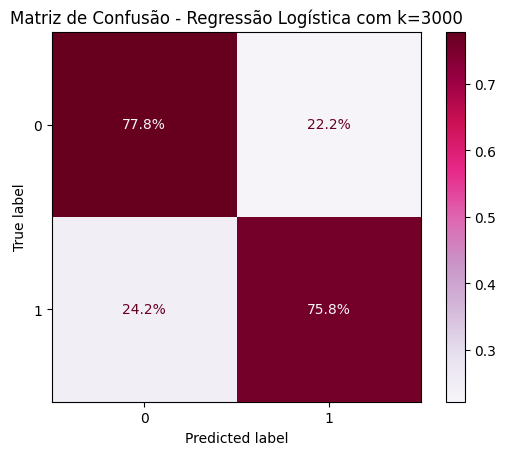

In [17]:
melhor_k = melhor['k']

# Separar os dados para avaliação final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Criar e treinar o modelo com o melhor k
pipe_final = Pipeline([
    ('select', SelectKBest(score_func=chi2, k=melhor_k)),
    ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42))
])
pipe_final.fit(X_train_final, y_train_final)

# Fazer previsões no teste final
y_pred_final = pipe_final.predict(X_test_final)
y_prob_final = pipe_final.predict_proba(X_test_final)[:, 1]

# Métricas
print(f"\n Avaliação Final do Melhor Modelo: Regressão Logística com k={melhor_k}")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_final.named_steps['LogisticRegression'].classes_)
disp.plot(cmap="PuRd", values_format=".1%")
plt.title(f"Matriz de Confusão - Regressão Logística com k={melhor_k}")
plt.show()

Naive Bayes

k=100 → F1 médio: 0.7495 | Desvio padrão: 0.1120
k=300 → F1 médio: 0.7677 | Desvio padrão: 0.1093
k=500 → F1 médio: 0.7615 | Desvio padrão: 0.1073
k=1000 → F1 médio: 0.7567 | Desvio padrão: 0.1165
k=2000 → F1 médio: 0.7658 | Desvio padrão: 0.1257
k=3000 → F1 médio: 0.7705 | Desvio padrão: 0.1166
k=5000 → F1 médio: 0.7844 | Desvio padrão: 0.1012
k=7000 → F1 médio: 0.7817 | Desvio padrão: 0.0984

 Melhor modelo: Naive Bayes com k=5000 → F1 médio: 0.7844


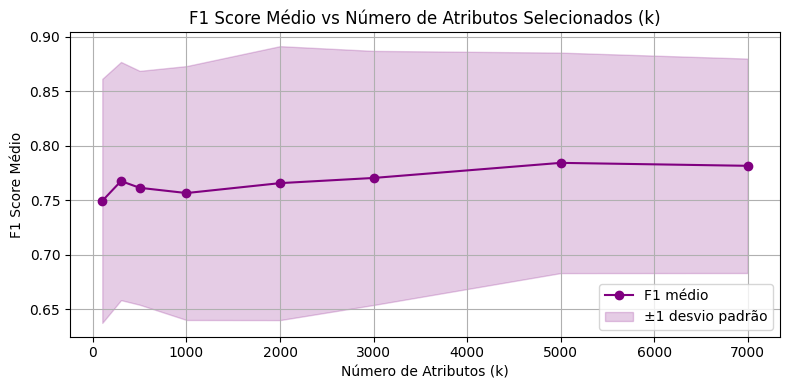

In [18]:
resultados = []

for k in k_values:
    pipe = Pipeline([
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('MultinomialNB', MultinomialNB())
    ])

    # Avaliação cruzada com valor de F1
    f1_scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    media = np.mean(f1_scores)
    std = np.std(f1_scores)

    resultados.append({
        "nome": f"Naive Bayes com k={k}",
        "k": k,
        "f1_mean": media,
        "f1_std": std,
        "scores": f1_scores
    })

    print(f"k={k} → F1 médio: {media:.4f} | Desvio padrão: {std:.4f}")

# Identificar o melhor valor de k com maior F1 médio
melhor = max(resultados, key=lambda x: x["f1_mean"])
print(f"\n Melhor modelo: {melhor['nome']} → F1 médio: {melhor['f1_mean']:.4f}")

# Gráfico da curva F1 vs k
plt.figure(figsize=(8, 4))
plt.plot([r['k'] for r in resultados], [r['f1_mean'] for r in resultados], marker='o', label='F1 médio', color='purple')
plt.fill_between(
    [r['k'] for r in resultados],
    [r['f1_mean'] - r['f1_std'] for r in resultados],
    [r['f1_mean'] + r['f1_std'] for r in resultados],
    color='purple', alpha=0.2, label='±1 desvio padrão'
)
plt.title("F1 Score Médio vs Número de Atributos Selecionados (k)")
plt.xlabel("Número de Atributos (k)")
plt.ylabel("F1 Score Médio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Avaliação Final do Melhor Modelo: Naive Bayes com k=5000
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        27
           1       0.75      0.73      0.74        33

    accuracy                           0.72        60
   macro avg       0.71      0.72      0.71        60
weighted avg       0.72      0.72      0.72        60

Accuracy: 0.7166666666666667
Precision: 0.75
Recall: 0.7272727272727273
F1 Score: 0.7384615384615385
ROC AUC Score: 0.8215488215488216


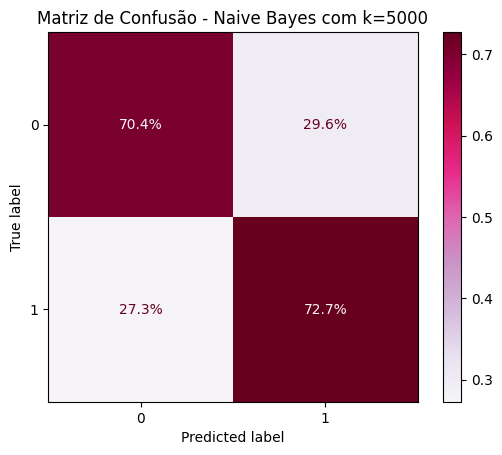

In [19]:
melhor_k = melhor['k']

# Separar os dados para avaliação final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Criar e treinar o modelo com o melhor k
pipe_final = Pipeline([
    ('select', SelectKBest(score_func=chi2, k=melhor_k)),
    ('MultinomialNB', MultinomialNB())
])
pipe_final.fit(X_train_final, y_train_final)

# Fazer previsões no teste final
y_pred_final = pipe_final.predict(X_test_final)
y_prob_final = pipe_final.predict_proba(X_test_final)[:, 1]

# Métricas
print(f"\n Avaliação Final do Melhor Modelo: Naive Bayes com k={melhor_k}")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_final.named_steps['MultinomialNB'].classes_)
disp.plot(cmap="PuRd", values_format=".1%")
plt.title(f"Matriz de Confusão - Naive Bayes com k={melhor_k}")
plt.show()

XGBoost

k=100 → F1 médio: 0.8289 | Desvio padrão: 0.0385
k=300 → F1 médio: 0.8368 | Desvio padrão: 0.0850
k=500 → F1 médio: 0.8470 | Desvio padrão: 0.0638
k=1000 → F1 médio: 0.8392 | Desvio padrão: 0.0739
k=2000 → F1 médio: 0.8530 | Desvio padrão: 0.0716
k=3000 → F1 médio: 0.8616 | Desvio padrão: 0.0534
k=5000 → F1 médio: 0.8437 | Desvio padrão: 0.0506
k=7000 → F1 médio: 0.8574 | Desvio padrão: 0.0586

 Melhor modelo: XGBoost com k=3000 → F1 médio: 0.8616


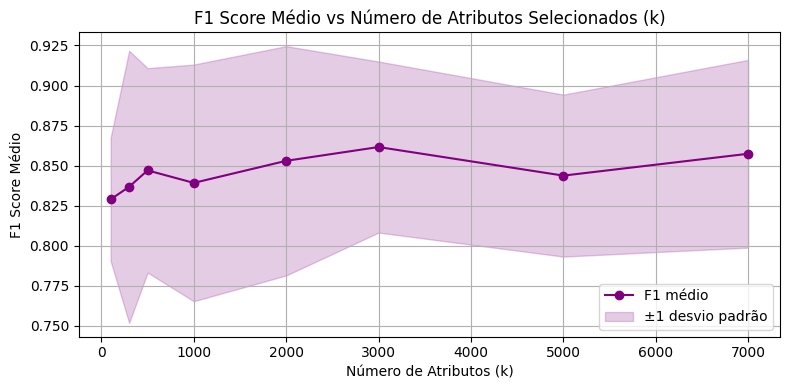

In [20]:
resultados = []

for k in k_values:
    pipe = Pipeline([
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42))
    ])

    # Avaliação cruzada com valor de F1
    f1_scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    media = np.mean(f1_scores)
    std = np.std(f1_scores)

    resultados.append({
        "nome": f"XGBoost com k={k}",
        "k": k,
        "f1_mean": media,
        "f1_std": std,
        "scores": f1_scores
    })

    print(f"k={k} → F1 médio: {media:.4f} | Desvio padrão: {std:.4f}")

# Identificar o melhor valor de k com maior F1 médio
melhor = max(resultados, key=lambda x: x["f1_mean"])
print(f"\n Melhor modelo: {melhor['nome']} → F1 médio: {melhor['f1_mean']:.4f}")

# Gráfico da curva F1 vs k
plt.figure(figsize=(8, 4))
plt.plot([r['k'] for r in resultados], [r['f1_mean'] for r in resultados], marker='o', label='F1 médio', color='purple')
plt.fill_between(
    [r['k'] for r in resultados],
    [r['f1_mean'] - r['f1_std'] for r in resultados],
    [r['f1_mean'] + r['f1_std'] for r in resultados],
    color='purple', alpha=0.2, label='±1 desvio padrão'
)
plt.title("F1 Score Médio vs Número de Atributos Selecionados (k)")
plt.xlabel("Número de Atributos (k)")
plt.ylabel("F1 Score Médio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Avaliação Final do Melhor Modelo: XGBoost com k=3000
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        27
           1       0.81      0.91      0.86        33

    accuracy                           0.83        60
   macro avg       0.84      0.82      0.83        60
weighted avg       0.84      0.83      0.83        60

Accuracy: 0.8333333333333334
Precision: 0.8108108108108109
Recall: 0.9090909090909091
F1 Score: 0.8571428571428571
ROC AUC Score: 0.8922558922558923


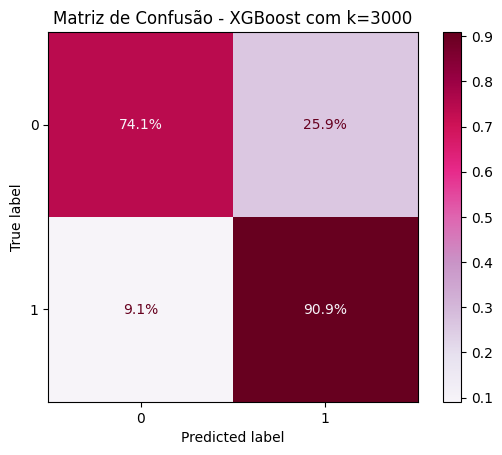

In [21]:
melhor_k = melhor['k']

# Separar os dados para avaliação final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Criar e treinar o modelo com o melhor k
pipe_final = Pipeline([
    ('select', SelectKBest(score_func=chi2, k=melhor_k)),
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42))
  ])
pipe_final.fit(X_train_final, y_train_final)

# Fazer previsões no teste final
y_pred_final = pipe_final.predict(X_test_final)
y_prob_final = pipe_final.predict_proba(X_test_final)[:, 1]

# Métricas
print(f"\n Avaliação Final do Melhor Modelo: XGBoost com k={melhor_k}")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_final.named_steps['XGBoost'].classes_)
disp.plot(cmap="PuRd", values_format=".1%")
plt.title(f"Matriz de Confusão - XGBoost com k={melhor_k}")
plt.show()

Random Forest

k=100 → F1 médio: 0.8258 | Desvio padrão: 0.0573
k=300 → F1 médio: 0.8556 | Desvio padrão: 0.0771
k=500 → F1 médio: 0.8458 | Desvio padrão: 0.0678
k=1000 → F1 médio: 0.8266 | Desvio padrão: 0.0830
k=2000 → F1 médio: 0.8288 | Desvio padrão: 0.0819
k=3000 → F1 médio: 0.8043 | Desvio padrão: 0.0753
k=5000 → F1 médio: 0.8103 | Desvio padrão: 0.0845
k=7000 → F1 médio: 0.8163 | Desvio padrão: 0.0838

 Melhor modelo: Floresta Aleatória com k=300 → F1 médio: 0.8556


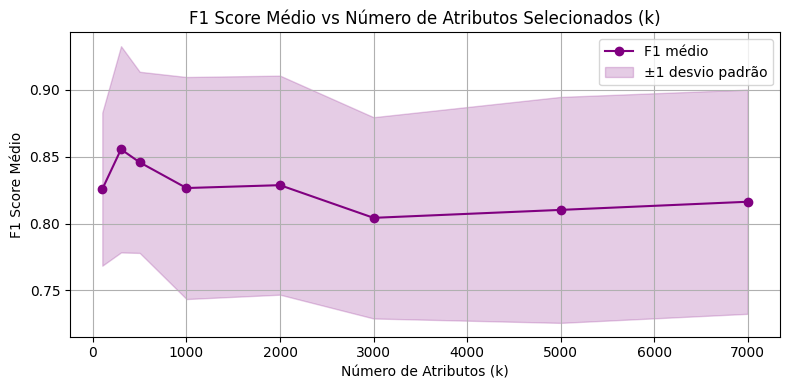

In [22]:
resultados = []

for k in k_values:
    pipe = Pipeline([
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Avaliação cruzada com valor de F1
    f1_scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    media = np.mean(f1_scores)
    std = np.std(f1_scores)

    resultados.append({
        "nome": f"Floresta Aleatória com k={k}",
        "k": k,
        "f1_mean": media,
        "f1_std": std,
        "scores": f1_scores
    })

    print(f"k={k} → F1 médio: {media:.4f} | Desvio padrão: {std:.4f}")

# Identificar o melhor valor de k com maior F1 médio
melhor = max(resultados, key=lambda x: x["f1_mean"])
print(f"\n Melhor modelo: {melhor['nome']} → F1 médio: {melhor['f1_mean']:.4f}")

# Gráfico da curva F1 vs k
plt.figure(figsize=(8, 4))
plt.plot([r['k'] for r in resultados], [r['f1_mean'] for r in resultados], marker='o', label='F1 médio', color='purple')
plt.fill_between(
    [r['k'] for r in resultados],
    [r['f1_mean'] - r['f1_std'] for r in resultados],
    [r['f1_mean'] + r['f1_std'] for r in resultados],
    color='purple', alpha=0.2, label='±1 desvio padrão'
)
plt.title("F1 Score Médio vs Número de Atributos Selecionados (k)")
plt.xlabel("Número de Atributos (k)")
plt.ylabel("F1 Score Médio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Avaliação Final do Melhor Modelo: Floresta Aleatória com k=300
              precision    recall  f1-score   support

           0       0.79      0.70      0.75        27
           1       0.78      0.85      0.81        33

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60

Accuracy: 0.7833333333333333
Precision: 0.7777777777777778
Recall: 0.8484848484848485
F1 Score: 0.8115942028985508
ROC AUC Score: 0.866442199775533


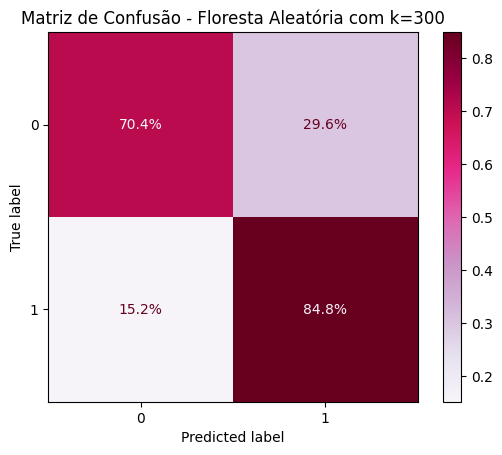

In [24]:
melhor_k = melhor['k']

# Separar os dados para avaliação final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Criar e treinar o modelo com o melhor k
pipe_final = Pipeline([
    ('select', SelectKBest(score_func=chi2, k=melhor_k)),
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42))
  ])
pipe_final.fit(X_train_final, y_train_final)

# Fazer previsões no teste final
y_pred_final = pipe_final.predict(X_test_final)
y_prob_final = pipe_final.predict_proba(X_test_final)[:, 1]

# Métricas
print(f"\n Avaliação Final do Melhor Modelo: Floresta Aleatória com k={melhor_k}")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_final.named_steps['RandomForest'].classes_)
disp.plot(cmap="PuRd", values_format=".1%")
plt.title(f"Matriz de Confusão - Floresta Aleatória com k={melhor_k}")
plt.show()

LightGBM

k=100 → F1 médio: 0.8160 | Desvio padrão: 0.0517
k=300 → F1 médio: 0.8432 | Desvio padrão: 0.0581
k=500 → F1 médio: 0.8365 | Desvio padrão: 0.0852
k=1000 → F1 médio: 0.8552 | Desvio padrão: 0.0730
k=2000 → F1 médio: 0.8634 | Desvio padrão: 0.0718
k=3000 → F1 médio: 0.8357 | Desvio padrão: 0.0697
k=5000 → F1 médio: 0.8413 | Desvio padrão: 0.0820
k=7000 → F1 médio: 0.8171 | Desvio padrão: 0.0803

 Melhor modelo: Floresta Aleatória com k=2000 → F1 médio: 0.8634


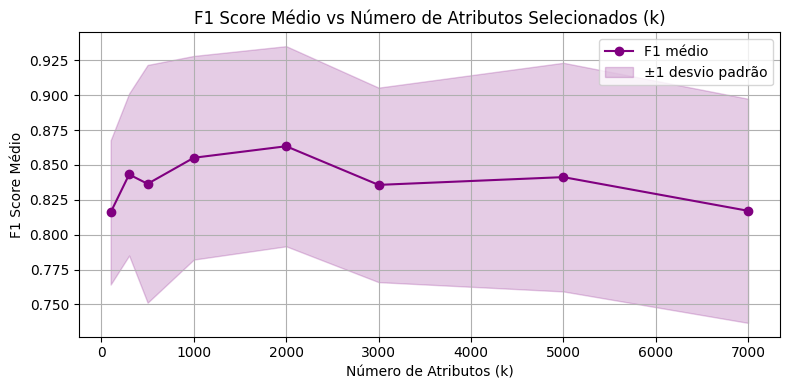

In [ ]:
resultados = []

for k in k_values:
    pipe = Pipeline([
        ('select', SelectKBest(score_func=chi2, k=k)),
        ('LightGBM', lgb.LGBMClassifier(random_state=42, verbose=-1))
    ])

    # Avaliação cruzada com valor de F1
    f1_scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    media = np.mean(f1_scores)
    std = np.std(f1_scores)

    resultados.append({
        "nome": f"Floresta Aleatória com k={k}",
        "k": k,
        "f1_mean": media,
        "f1_std": std,
        "scores": f1_scores
    })

    print(f"k={k} → F1 médio: {media:.4f} | Desvio padrão: {std:.4f}")

# Identificar o melhor valor de k com maior F1 médio
melhor = max(resultados, key=lambda x: x["f1_mean"])
print(f"\n Melhor modelo: {melhor['nome']} → F1 médio: {melhor['f1_mean']:.4f}")

# Gráfico da curva F1 vs k
plt.figure(figsize=(8, 4))
plt.plot([r['k'] for r in resultados], [r['f1_mean'] for r in resultados], marker='o', label='F1 médio', color='purple')
plt.fill_between(
    [r['k'] for r in resultados],
    [r['f1_mean'] - r['f1_std'] for r in resultados],
    [r['f1_mean'] + r['f1_std'] for r in resultados],
    color='purple', alpha=0.2, label='±1 desvio padrão'
)
plt.title("F1 Score Médio vs Número de Atributos Selecionados (k)")
plt.xlabel("Número de Atributos (k)")
plt.ylabel("F1 Score Médio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Avaliação Final do Melhor Modelo: LightGBM com k=2000
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        27
           1       0.85      0.85      0.85        33

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

Accuracy: 0.8333333333333334
Precision: 0.8484848484848485
Recall: 0.8484848484848485
F1 Score: 0.8484848484848485
ROC AUC Score: 0.9079685746352413


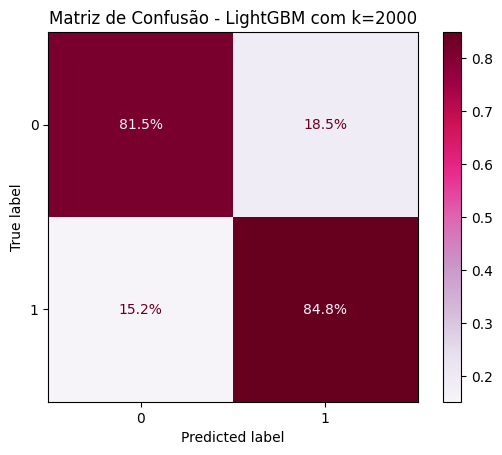

In [25]:
melhor_k = melhor['k']

# Separar os dados para avaliação final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Criar e treinar o modelo com o melhor k
pipe_final = Pipeline([
    ('select', SelectKBest(score_func=chi2, k=melhor_k)),
    ('lightgbm', lgb.LGBMClassifier(random_state=42, verbose=-1))
  ])
pipe_final.fit(X_train_final, y_train_final)

# Fazer previsões no teste final
y_pred_final = pipe_final.predict(X_test_final)
y_prob_final = pipe_final.predict_proba(X_test_final)[:, 1]

# Métricas
print(f"\n Avaliação Final do Melhor Modelo: LightGBM com k={melhor_k}")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_final.named_steps['lightgbm'].classes_)
disp.plot(cmap="PuRd", values_format=".1%")
plt.title(f"Matriz de Confusão - LightGBM com k={melhor_k}")
plt.show()